In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

from pygama.analysis.peak_fitting import gauss_mode_width_max
from pygama import DataGroup, lh5


dsp_dir = '/global/cfs/cdirs/legend/data/cage/LH5/dsp'

# Timestamp Correction

In [2]:
#def dsp_to_hit_cage(f_dsp, f_hit, dg, n_max=None, verbose=False, t_start=None):
    
def correct_timestamps(f_dsp):
    dsp = h5py.File(f_dsp)
    ts_old = np.array(dsp['ORSIS3302DecoderForEnergy']['dsp']['timestamp'])
    ts_old = ts_old.astype(np.int64)
    ts_sec = []
    clock = 100e6 # 100 MHz
    UINT_MAX = 4294967295 # (0xffffffff)
    t_max = UINT_MAX / clock
    ts = ts_old/ clock
    tdiff = np.diff(ts)
    tdiff = np.insert(tdiff, 0 , 0)
    iwrap = np.where(tdiff < 0)
    iloop = np.append(iwrap[0], len(ts))
    ts_new, t_roll = [], 0
    for i, idx in enumerate(iloop):
        ilo = 0 if i==0 else iwrap[0][i-1]
        ihi = idx
        ts_block = ts[ilo:ihi]
        ts_block = (np.array(ts_block)).astype(np.uint64)
        ts_new.append(ts_block + t_roll)
        t_last = ts[ilo-1]
        t_diff = t_max - t_last
        t_roll += t_last + t_diff
    ts_sec = np.concatenate(ts_new)
    return ts_sec

# Gain Jumps

In [26]:
time_intervals = 60

def find_1460(timestamps, trapEftp):
    ehist, t_edges, e_edges = np.histogram2d(timestamps,  trapEftp, bins=[np.arange(0, timestamps[-1], np.minimum(time_intervals, int(timestamps[-1]-1))), np.arange(1000,5000, 10)])
    ind = np.unravel_index(np.argmax(ehist), ehist.shape)
    return e_edges[ind[1]]

def hist_jump_in_run(run, cycles, dsp_folder, plot=True):
    ehists = []
    blhists = []
#    esig = 0
#    blsig = 0
    r = run
    for c in cycles:
        f_dsp = f"{dsp_folder}/cage_run{r}_cyc{c}_dsp.lh5"
        try:
            dsp = h5py.File(f_dsp)
        except OSError:
            continue
        trapEftp = np.array(dsp['ORSIS3302DecoderForEnergy']['dsp']['trapEftp'])
        baseline = np.array(dsp['ORSIS3302DecoderForEnergy']['dsp']['bl'])
        ts = np.array(dsp['ORSIS3302DecoderForEnergy']['dsp']['timestamp'])
        ts_corrected = correct_timestamps(f_dsp)
        bl = np.mean(baseline)
        adu1460 = find_1460(ts_corrected, trapEftp)
        if plot:
            plt.figure(figsize=(15,10))
            blh = plt.hist2d(ts_corrected, baseline, bins=[np.arange(0, ts_corrected[-1], np.minimum(time_intervals, int(ts_corrected[-1]-1))),np.arange(bl - 100, bl+100)])[:-1]
            yb = [blh[2][np.argmax(blh[0][j][:])] for j in range(0, len(blh[1])-1)]
            plt.plot(blh[1][:-1], yb, color='red')
            plt.xlabel('time')
            plt.ylabel('baseline')
            plt.title(f'run{r} cycle{c} baseline')
            plt.show()
            plt.figure(figsize=(15,10))
            eh = plt.hist2d(ts_corrected, trapEftp, bins=[np.arange(0, ts_corrected[-1],np.minimum(time_intervals, int(ts_corrected[-1]-1))),np.arange(adu1460-250, adu1460+250)])[:-1]
            ye = [eh[2][np.argmax(eh[0][j][:])] for j in range(0, len(eh[1])-1)]
            plt.plot(eh[1][:-1], ye, color='red')
            plt.xlabel('time')
            plt.ylabel('trapEftp')
            plt.title(f'run{r} cycle{c} trapEftp')
            plt.show()
        else:
            blh = np.histogram2d(ts_corrected, baseline, bins=[np.arange(0, ts_corrected[-1], np.minimum(time_intervals, int(ts_corrected[-1]-1))), np.arange(bl - 100, bl+100)])
            eh = np.histogram2d(ts_corrected, trapEftp, bins=[np.arange(0, ts_corrected[-1], np.minimum(time_intervals, int(ts_corrected[-1]-1))), np.arange(adu1460-250, adu1460+250)])
#        edata = eh[0]
#        e_edges = eh[2]
#        e_guess = e_edges[np.argmax(edata,axis=1)]
#        print(c, len(e_guess))
#        res = np.mean([gauss_mode_width_max(edata[j], e_edges, mode_guess=e_guess[j], n_bins=8)[0][1] for j in range(len(eh[1]))])
#        esig += res
        ehists.append(eh)
        blhists.append(blh)
#    esig /= len(cycles)
#    blsig /= len(cycles)
    return ehists, blhists#, esig, blsig
            
#returns (time, adu, cycle index)
def find_jump_in_run(cycles, ehist_infos, bhist_infos, thresholds):
    assert len(ehist_infos) == len(bhist_infos)
    ret = []
    for i in np.arange(len(ehist_infos)):
        ehist, t_edges, e_edges = ehist_infos[i]
        bhist, t_edges, b_edges = bhist_infos[i]
        ye = [e_edges[np.argmax(ehist[j][:])] for j in range(0, len(t_edges)-1)]
        yemean = np.mean(ye)
        ye -= yemean
        yb = [b_edges[np.argmax(bhist[j][:])] for j in range(0, len(t_edges)-1)]
        ybmean = np.mean(yb)
        yb -= ybmean
        step = np.hstack((np.ones(int(len(ye))), -1*np.ones(int(len(ye)))))
        econvolved = np.convolve(ye, step, mode='valid')
        bconvolved = np.convolve(yb, step, mode='valid')
        estep_index = np.argmax(np.abs(econvolved)) 
        bstep_index = np.argmax(np.abs(bconvolved)) 
        eleft = np.mean(ye[np.maximum(estep_index-10, 0):np.maximum(estep_index-1,0)])
        eright = np.mean(ye[np.minimum(estep_index+1, len(ye)):np.minimum(estep_index+10,len(ye))])
        bleft = np.mean(yb[np.maximum(bstep_index-10, 0):np.maximum(bstep_index-1,0)])
        bright = np.mean(yb[np.minimum(bstep_index+1, len(yb)):np.minimum(bstep_index+10,len(yb))])
        ejump = eright-eleft
        bjump = bright-bleft     
        if np.abs(ejump) > thresholds[0] or np.abs(bjump) > thresholds[1]:
            plt.figure(figsize=(12,8))
            plt.imshow(np.transpose(ehist), extent=(t_edges[0], t_edges[-1], e_edges[0], e_edges[-1]), aspect='auto', origin='lower')
            plt.plot(t_edges[:-1], ye + yemean, color='red')
            plt.axvline(t_edges[estep_index],color='orange')
            plt.xlabel('timestamp')
            plt.ylabel('trapEftp')
            plt.title(f'cycle {cycles.iloc[i]} trapEftp')
            ret.append( (t_edges[estep_index], ejump, i, 'e') )
            plt.figure(figsize=(12,8))
            plt.imshow(np.transpose(bhist), extent=(t_edges[0], t_edges[-1], b_edges[0], b_edges[-1]), aspect='auto', origin='lower')
            plt.plot(t_edges[:-1], yb + ybmean, color='red')
            plt.axvline(t_edges[bstep_index],color='orange')
            plt.xlabel('timestamp')
            plt.ylabel('baseline')
            plt.title(f'cycle {cycles.iloc[i]} baseline')
            ret.append( (t_edges[bstep_index], bjump, i, 'b') )
    return ret

#a jump is a list [run, cycle, time, adu]
def find_jumps(runs, dsp_folder):
    en_jumps = []
    bl_jumps = []
    for i in range(len(runs)):
        r = runs[i]
        dg = DataGroup('../processing/cage.json', load=True)
        df = dg.fileDB.query(f'run == {r}')
        ehists, blhists = hist_jump_in_run(r, df['cycle'], dsp_folder, False)
        jumps = find_jump_in_run(df['cycle'], ehists, blhists, [15, 3])
        if jumps is not None:
            for jump in jumps:
                if jump[-1] == 'e':
                    ejump = [r, df['cycle'].iloc[jump[2]], jump[0], jump[1]]
                    en_jumps.append(ejump)
                if jump[-1] == 'b':
                    bjump = [r, df['cycle'].iloc[jump[2]], jump[0], jump[1]]
                    bl_jumps.append(bjump)
    return (en_jumps, bl_jumps)

/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


([[107, 1167, 180.0, -24.833333333333332],
  [109, 1183, 660.0, -94.0],
  [111, 1191, 600.0, 50.333333333333336]],
 [[107, 1167, 180.0, 8.61111111111111],
  [109, 1183, 840.0, 0.4722222222222222],
  [111, 1191, 1320.0, 0.4444444444444444]])

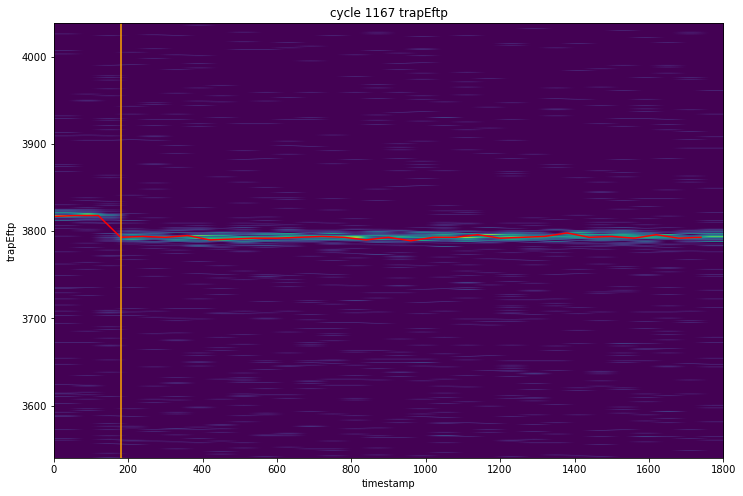

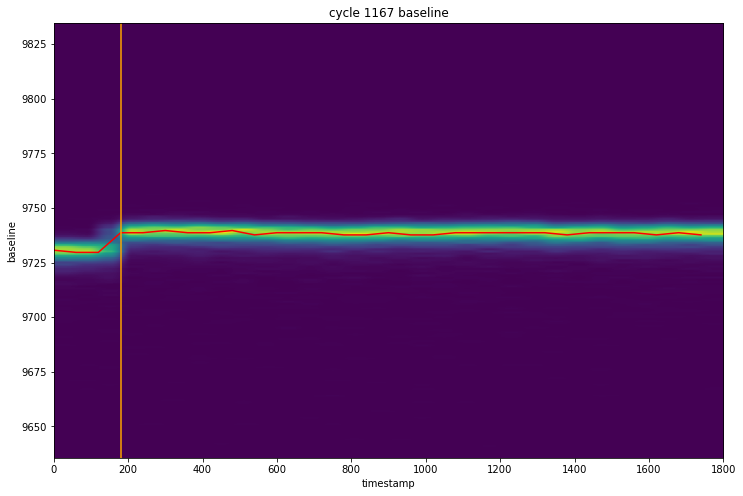

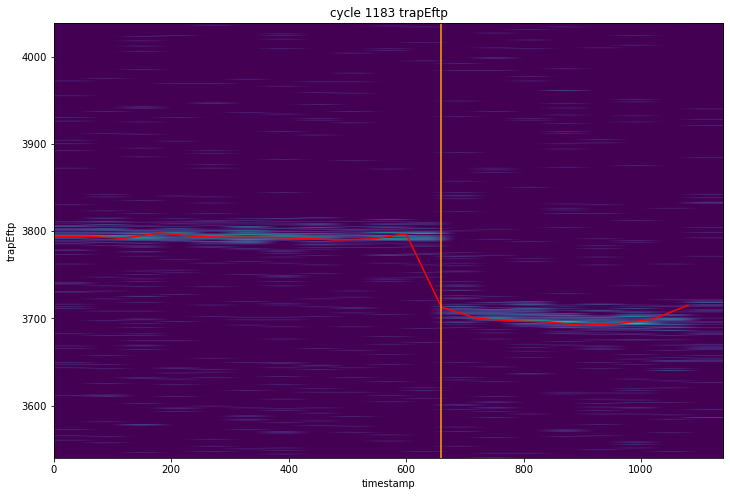

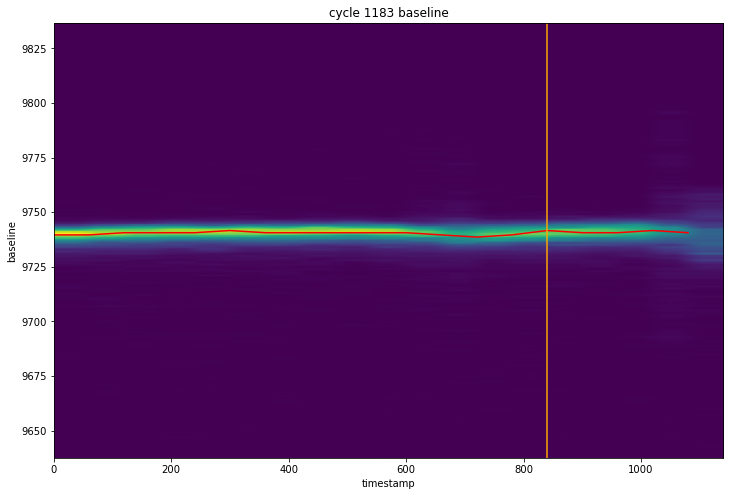

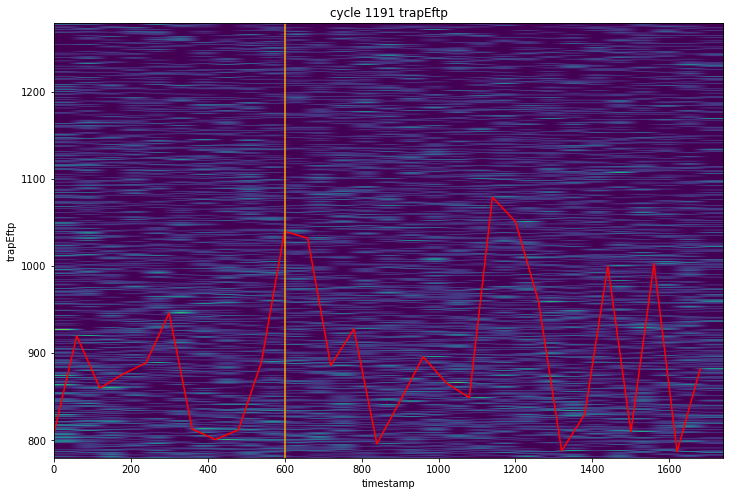

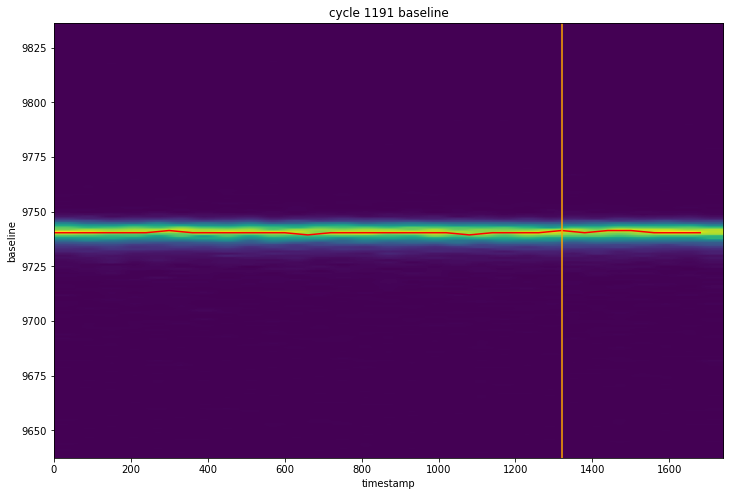

In [27]:
runs=np.arange(107,234)
find_jumps(runs,dsp_dir)

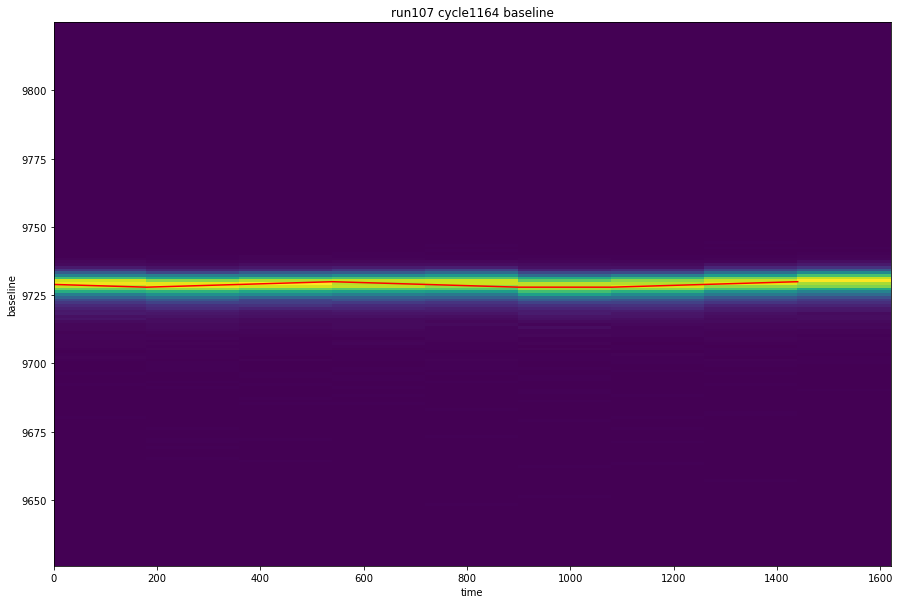

3821.777777777778


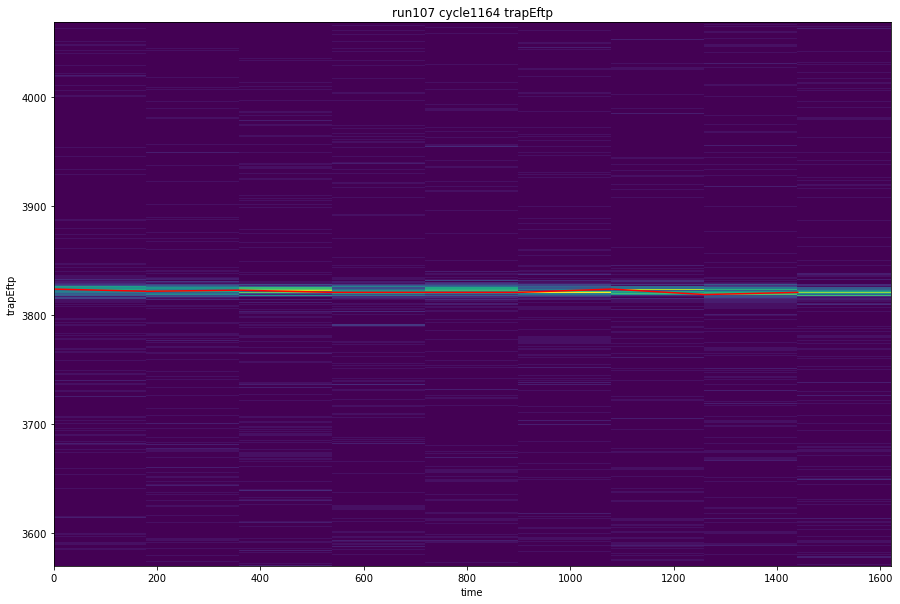

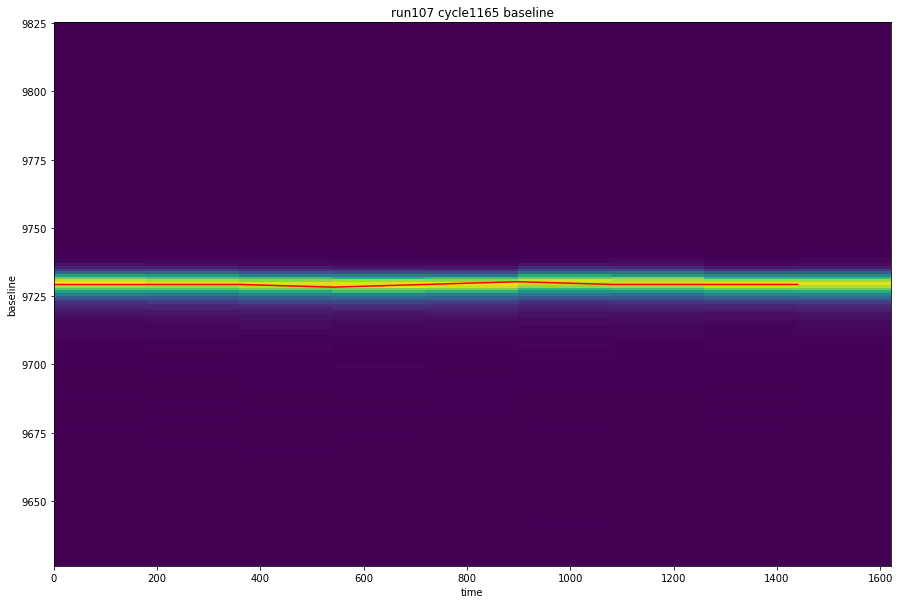

3820.3333333333335


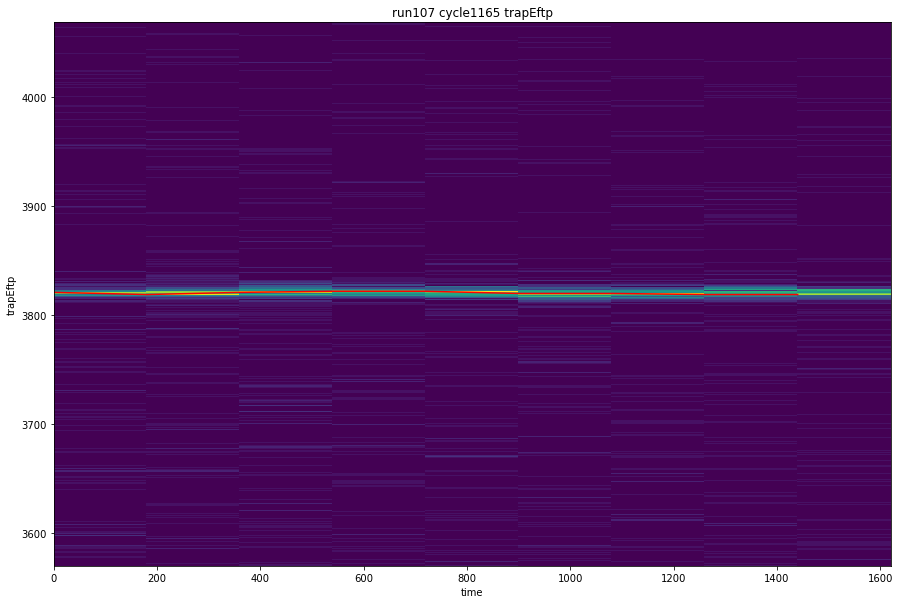

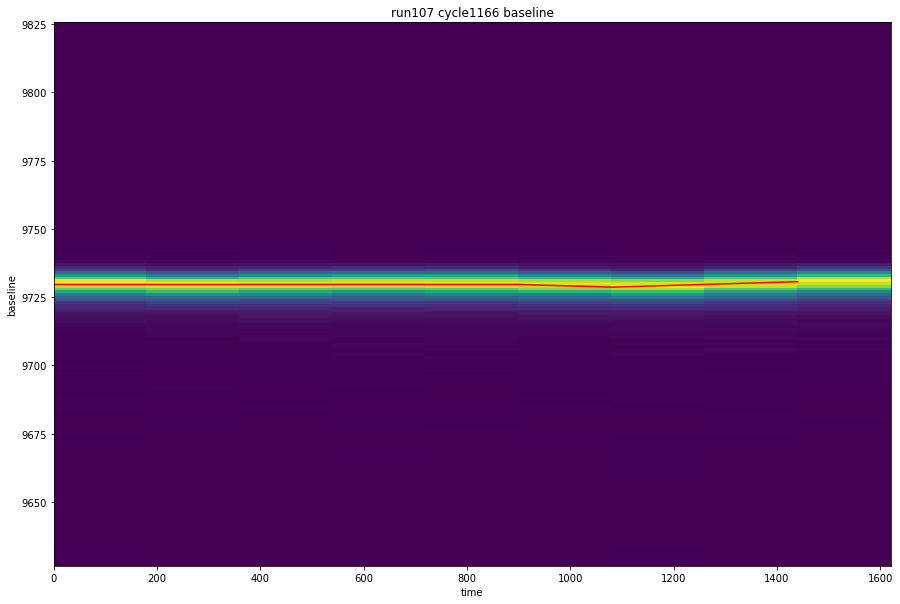

3819.6666666666665


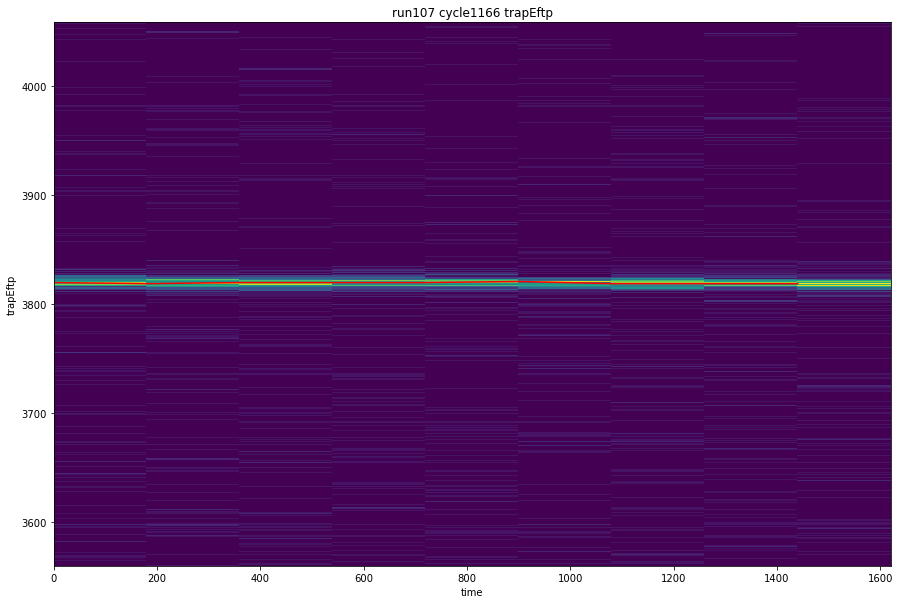

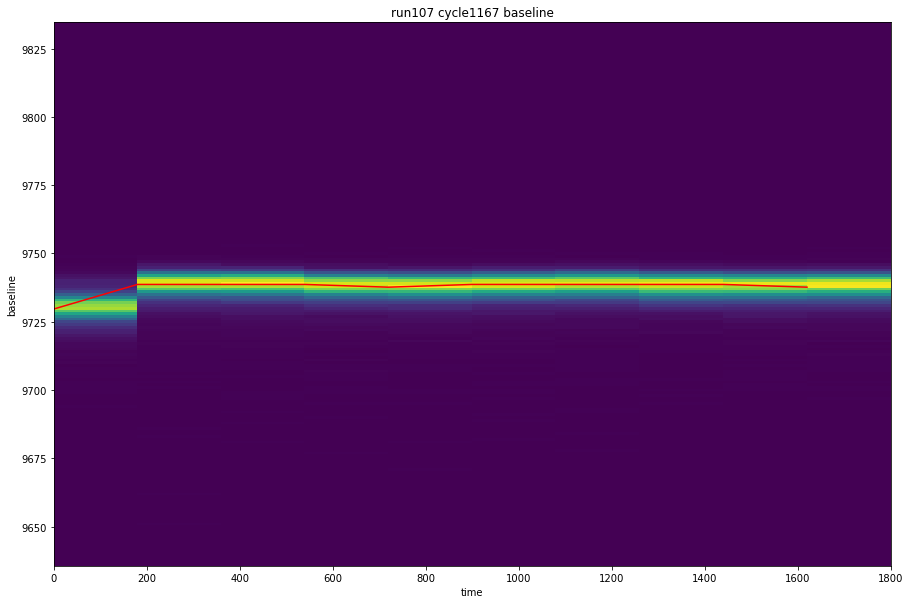

3794.9


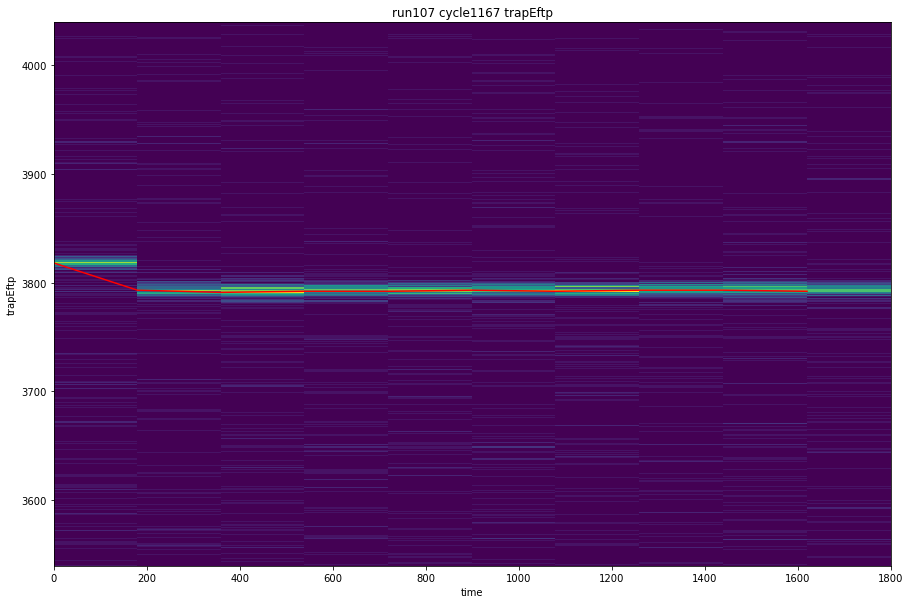

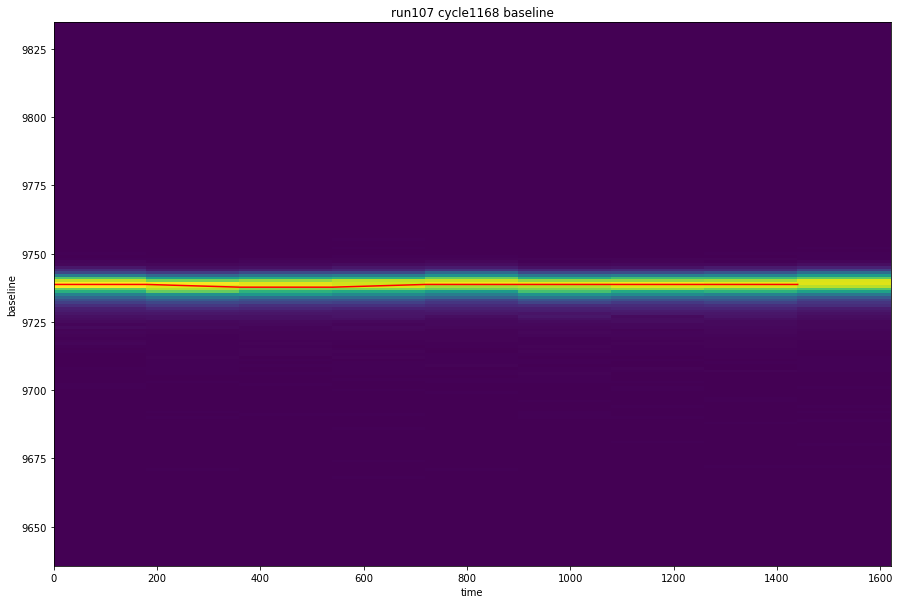

3793.4444444444443


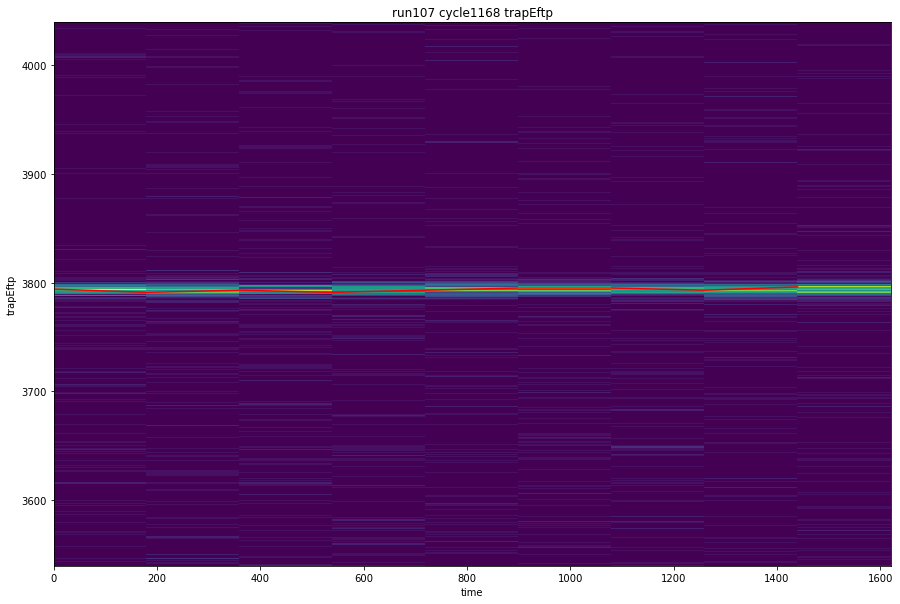

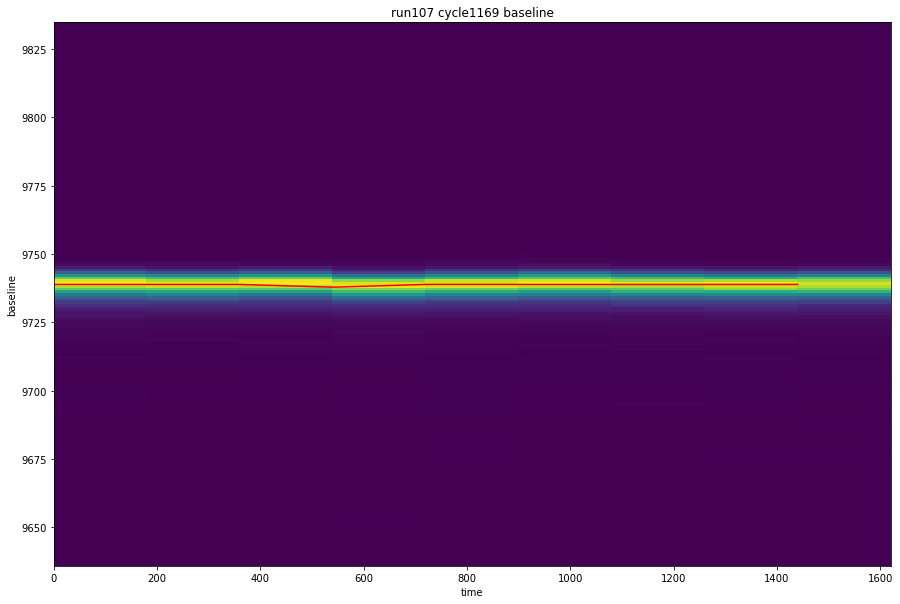

3793.222222222222


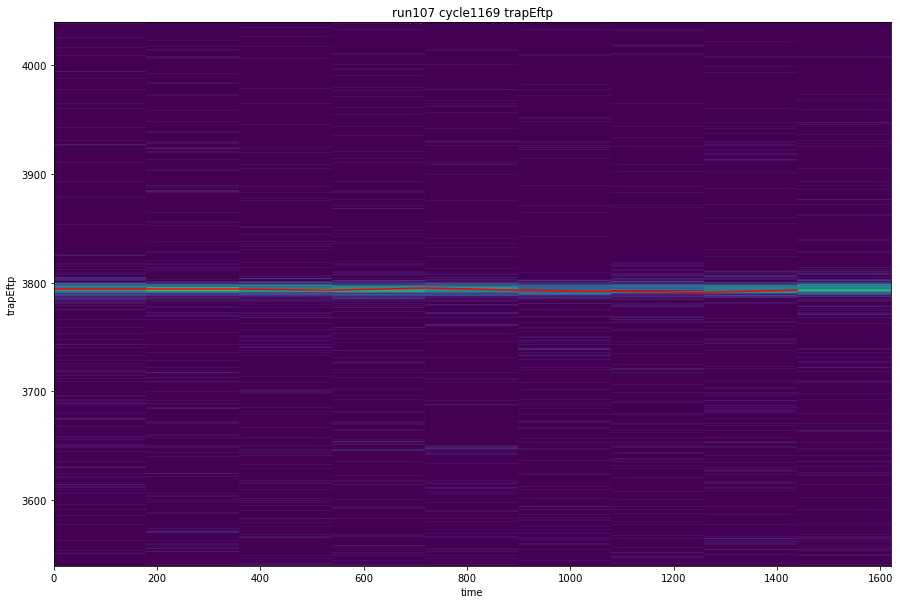

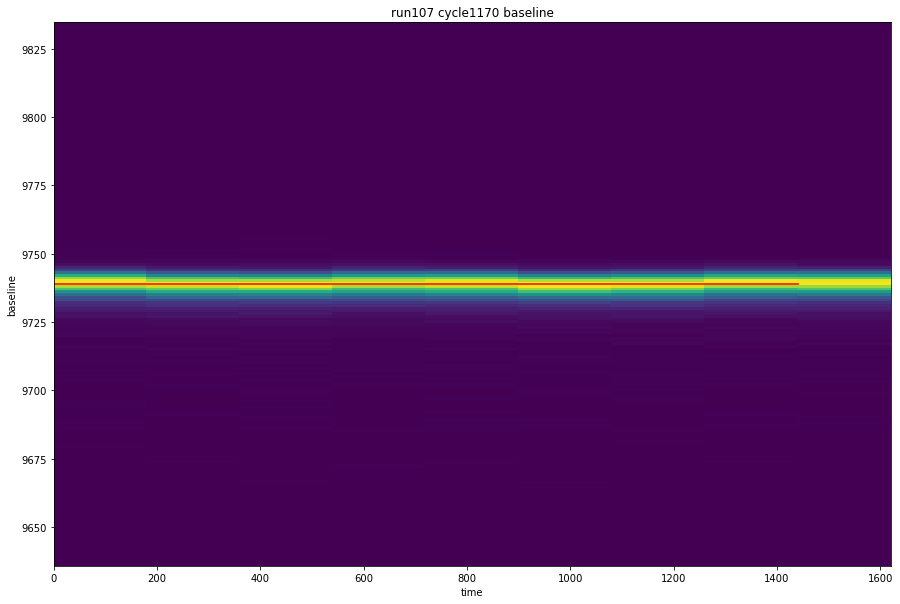

3794.0


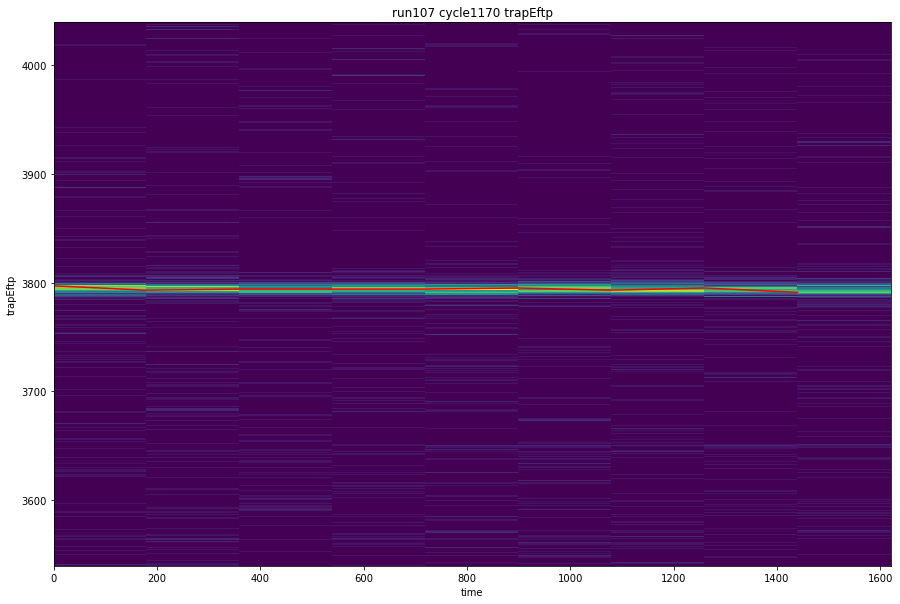

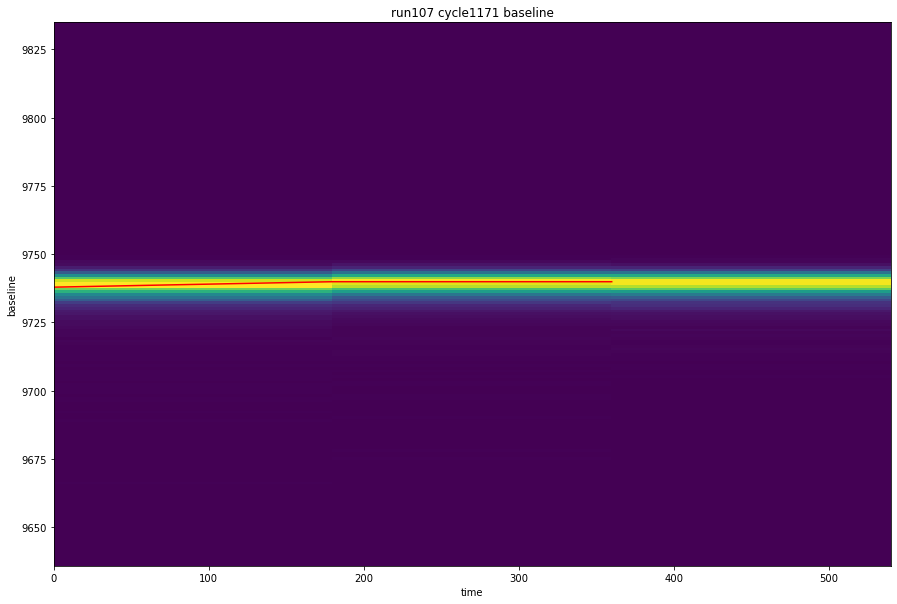

3793.0


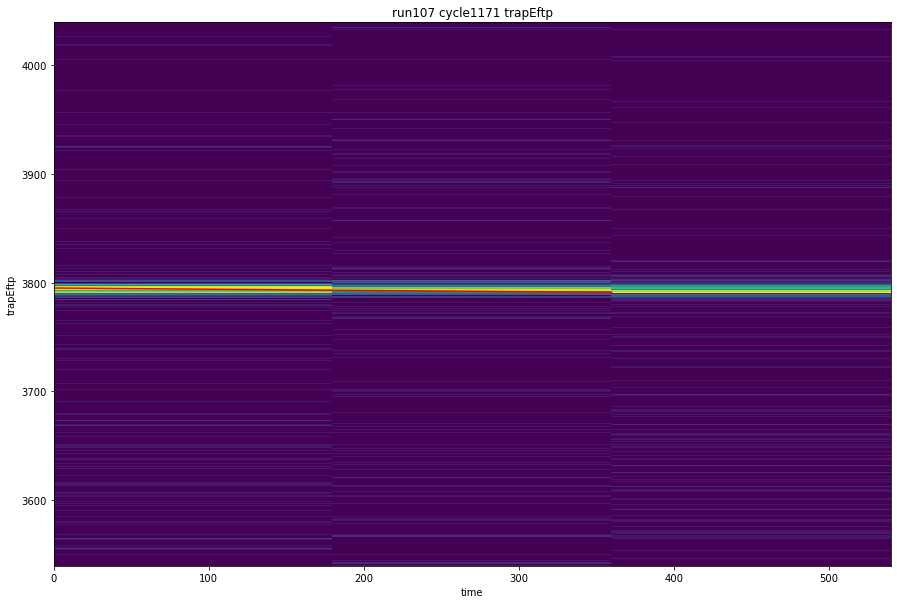

ValueError: too many values to unpack (expected 2)

In [69]:
run = 107
cycles = np.arange(1164,1172)
ehists, blhists = hist_jump_in_run(run, cycles, dsp_dir, True)

# Peak Fitting

1
[3.7572449450685648, 2.0960235227129256, 1.5149257771246811, 2.3616780366373367]


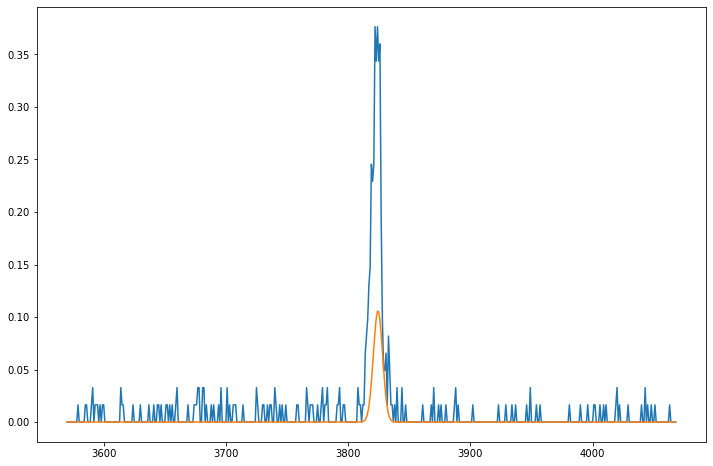

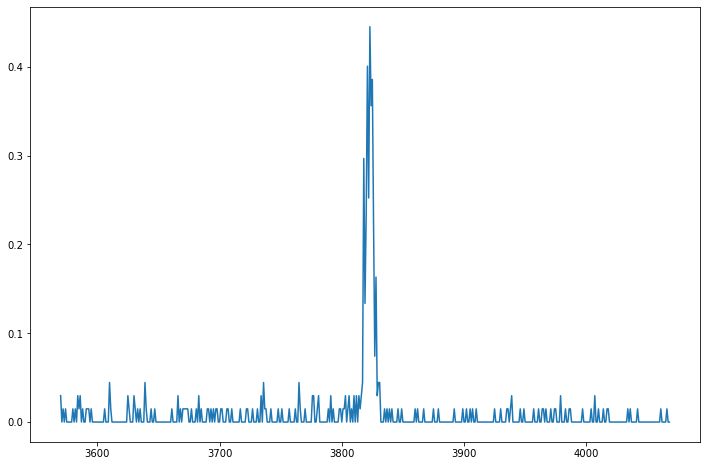

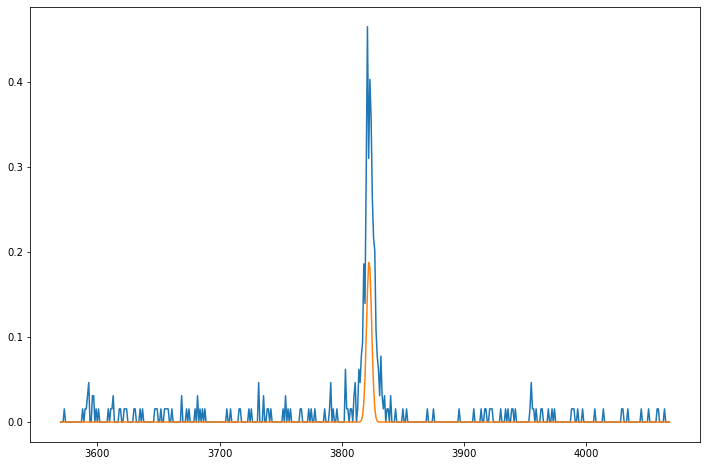

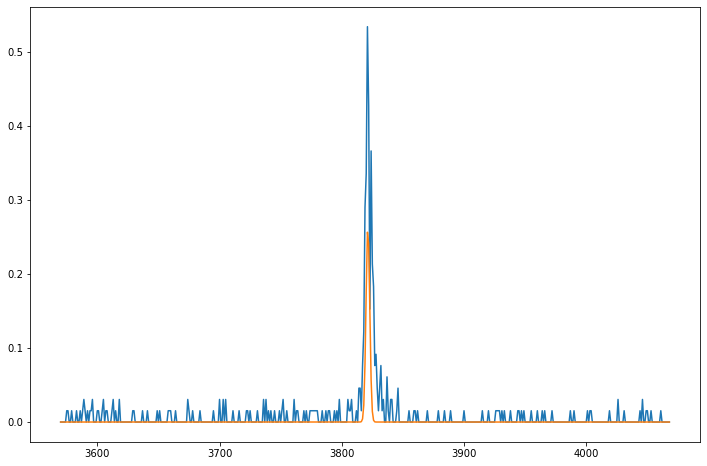

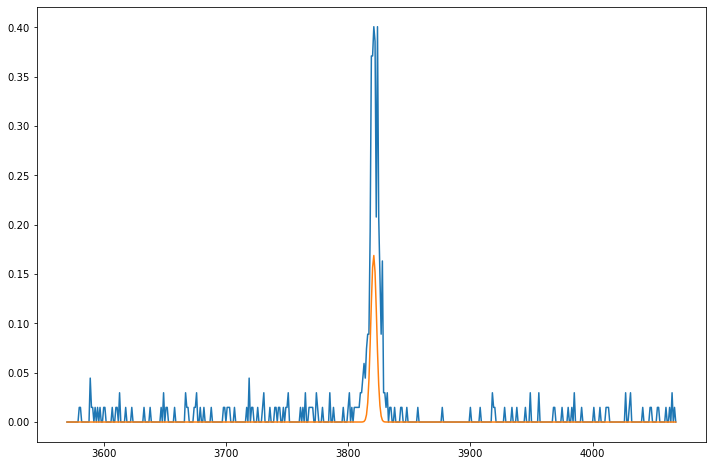

In [48]:
from scipy.stats import norm

run = 107
cycles = np.arange(1164,1172)
ehists, blhists, _, _ = hist_jump_in_run(run, cycles, dsp_dir, False)

edata = ehists[0][0]
t_edges = ehists[0][1]
e_edges = ehists[0][2]
res = []
for j in range(len(t_edges)-1):
    try:
        plt.figure(figsize=(12,8))
        plt.plot(e_edges[:-1], edata[j]/np.linalg.norm(edata[j]))
        par = gauss_mode_width_max(edata[j], e_edges, mode_guess=e_edges[np.argmax(edata[j])], n_bins=5)[0]
        plt.plot(e_edges[:-1], norm.pdf(e_edges[:-1], loc=par[0], scale=par[1]))
        res.append(par[1])
    except RuntimeError:
        print(j)
print(res)

In [ ]:
run = 107
cycles = np.arange(1164,1172)
ehists, blhists, _, _ = hist_jump_in_run(run, cycles, dsp_dir, True)